In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import sys
import getopt
import yaml
from optics.algorithms import opticSiren
from optics.external.wcte import *
from optics.utils import list_config, get_config, load_config
from optics.models.siren import *
import h5py
import torch
import numpy as np
from tqdm import tqdm

In [69]:
def read_pmtQ(filename):
    with h5py.File(filename,'r') as f:
        pmtQ = torch.as_tensor(f['pmtQ'][:])
        t0t1 = torch.as_tensor(f['tof'][:])
    return pmtQ, t0t1

# Beam data configs
vertex_momentum = 280
fname = 'muon_run1994_wTOF.h5'
# evnet display to fit
pmtQ_data, tof_data = read_pmtQ(fname)
nev = int(pmtQ_data.shape[0])
print('nev = ',nev)

# Brute force channel masking based on observed PMT hits
pmt_mask = torch.sum(pmtQ_data,axis=0)
pmt_mask[pmt_mask>0] = 1

nev =  3620


(array([  0.,   1.,   0.,   0.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,
          1.,   1.,   2.,   1.,   2.,   0.,   0.,   3.,   0.,   4.,   3.,
          7.,   1.,   2.,   3.,   5.,   2.,   9.,   8.,   8.,   8.,   6.,
          5.,   8.,   7.,   4.,   8.,   5.,   9.,  14.,  14.,  17.,  18.,
         15.,  16.,  24.,  20.,  30.,  36.,  30.,  26.,  35.,  27.,  43.,
         42.,  87.,  66.,  64.,  65.,  58.,  72.,  73., 109., 127.,  88.,
         92., 100., 109., 109., 117., 153.,  84., 100.,  98., 101.,  96.,
         79.,  92.,  94.,  75.,  57.,  69.,  53.,  70.,  43.,  69.,  30.,
         37.,  31.,  25.,  27.,  19.,  28.,  33.,  14.,   9.,  18.,  12.,
         12.,  13.,   7.,  14.,   7.,   1.,   5.,   3.,   2.,   0.,   3.,
          3.,   5.,   0.,   0.,   2.,   3.,   4.,   1.,   0.,   1.,   0.,
          0.,   1.,   4.,   0.,   1.,   1.,   1.,   1.,   3.,   3.,   4.,
          0.,   1.,   1.,   1.,   0., 

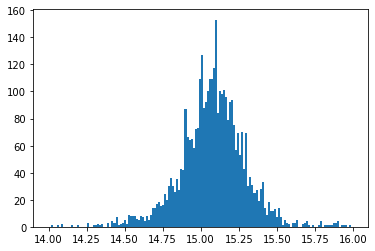

In [81]:
plt.hist(tof_data,bins=150,range=[14,16])

In [4]:
"""
Input normalization for Cherenkov Siren
"""
def momentum_normalization(val):
    return (val-525)/475

def distance_normalization(val):
    return (val-3000)/3000

def costh_normalization(val):
    return val

"""
Conversion from Cherenkov emission angle to OpticSiren angular input
"""
def get_direction(dir,costh,nphi):
    #dir = torch.tensor(dir, dtype=torch.float32)  # Ensure tensor input
    xx, yy, zz = dir ** 2

    # Compute dirx efficiently
    if xx < yy and xx < zz:
        inv_norm = 1.0 / torch.sqrt(zz + yy)
        dirx = torch.tensor([0, dir[2] * inv_norm, -dir[1] * inv_norm])
    elif yy < zz:
        inv_norm = 1.0 / torch.sqrt(xx + zz)
        dirx = torch.tensor([-dir[2] * inv_norm, 0, dir[0] * inv_norm])
    else:
        inv_norm = 1.0 / torch.sqrt(xx + yy)
        dirx = torch.tensor([dir[1] * inv_norm, -dir[0] * inv_norm, 0])

    # Compute diry using torch.cross for efficiency
    diry = torch.linalg.cross(dir, dirx)

    # Ensure costh is a 1D tensor
    # costh = torch.as_tensor(costh, dtype=torch.float32)

    # Precompute sin(theta) for efficiency
    sin_theta = torch.sqrt(1 - costh ** 2)

    # Generate sample_phi values (avoiding unnecessary reshaping)
    sample_phi = torch.linspace(0, 2 * np.pi - 2 * np.pi / nphi, nphi)

    # Compute sin and cos of sample_phi
    cos_phi, sin_phi = torch.cos(sample_phi), torch.sin(sample_phi)

    # Compute sample_dir using efficient broadcasting
    sample_dir = (
        costh[:, None, None] * dir +  # Expand costh along the required dimensions
        sin_theta[:, None, None] * (cos_phi[None, :, None] * dirx + sin_phi[None, :, None] * diry)
    )

    # Flatten sample_dir while keeping the last dimension intact
    sample_dir = sample_dir.reshape(-1, 3)

    # Compute angles efficiently
    dir_th = torch.acos(sample_dir[:, 2]) * (180 / np.pi)
    dir_phi = torch.atan2(sample_dir[:, 1], sample_dir[:, 0]) * (180 / np.pi)
    dir_phi[dir_phi<0] = dir_phi[dir_phi<0]+360

    return torch.stack((dir_phi, dir_th), dim=-1)

In [5]:
"""
Assumed parameters
"""
pmt_qe = 0.35 # not included in OpticSirn

# Load config
with open('./optics/config/forward_simulation.yaml','r') as f:
    cfg=yaml.safe_load(f)

device = cfg['device']['type'] 
if not torch.cuda.is_available():
    device = 'cpu'

# WCTE beam positions and directions
vertex_position = torch.tensor([0,1348.763,-424.7625], dtype=torch.float32)
vertex_direction = torch.tensor([0,-1,0], dtype=torch.float32)
vertex_direction_2d = [torch.atan2(vertex_direction[1],vertex_direction[0])*(180/np.pi),torch.acos(vertex_direction[2])*(180/np.pi)]
if vertex_direction_2d[0]<0:
    vertex_direction_2d[0] = vertex_direction_2d[0]+360

# Sampling along s
distance_step = 5 # step size
distance_min = 5
distance_max = 2795 # distance from beam pipe to mPMT on the other side
sample_distance = torch.tensor([(distance_min+distance_step*i) for i in range(int((distance_max-distance_min)/distance_step+1))], dtype=torch.float32)
sample_position = vertex_position[None,:]+ sample_distance[:,None]*vertex_direction[None,:]
sample_position = sample_position.reshape(-1, 3)

# Sampling along costh
costh_step = 0.025 # step size
costh_min = -0.975
costh_max = 0.975
costh = torch.tensor([(costh_min+costh_step*interval) for interval in range(int((costh_max-costh_min)/costh_step+1))], dtype=torch.float32)
nphi = 72 # number of azimuthal emission bins
sample_direction = get_direction(vertex_direction,costh,nphi)

# Convert to Cherenkov Siren inputs
cherenkov_siren_input = tuple( [torch.tensor([momentum_normalization(vertex_momentum)], dtype=torch.float32), distance_normalization(sample_distance),costh] )
cherenkov_siren_input = torch.stack(torch.meshgrid(*cherenkov_siren_input, indexing='ij'), dim=-1)
cherenkov_siren_input = cherenkov_siren_input.reshape(-1, 3)
cherenkov_siren_input[:, [1, 2]] = cherenkov_siren_input[:, [2, 1]]

# Load Cherenkov Siren
cprof_cfg = cfg['cprof']
cherenkov_siren = Siren(**cprof_cfg['network']).to(device)
cprof_file = cprof_cfg['file'] 
cherenkov_siren.load_state_dict(torch.load(cprof_file, map_location='cpu'))
cherenkov_siren.eval()

# Load Optic Siren model
model = opticSiren(cfg).to(device)
Qpred = []
Qtarg = []
loss = []
Qmax = float(cfg['data']['dataset']['Qmax'])
n_gamma_model = float(cfg['model']['n_gamma'])
npmt = int(cfg['data']['dataset']['npmt_max'])

# Efficiently generate index pairs
optic_siren_input_idx = torch.cartesian_prod(
    torch.arange(sample_position.shape[0]),
    torch.arange(sample_direction.shape[0])
)

# Generate input for Optic Siren
optic_siren_input_dir = sample_direction[optic_siren_input_idx[:,1], :2]  # Take first two columns
optic_siren_input_pos = sample_position[optic_siren_input_idx[:, 0], :3]  # Take first two columns

# Create Optic Siren response
npt = sample_position.shape[0]*sample_direction.shape[0]

nbatch = 100
batches = []
pred = []
batch_size = (int(npt*1./nbatch/nphi)+1)*nphi
# Run Optic Siren
print("Compute Optic Siren response")
with torch.no_grad():
    for b in tqdm(range(nbatch)):
        sel = slice(b*batch_size, (b+1)*batch_size)
        batch = {}
        batch['dirGamma'] = optic_siren_input_dir[sel]
        batch['posGamma'] = optic_siren_input_pos[sel]
        batch['nGamma'] = torch.ones((batch['dirGamma'].shape[0],), dtype=torch.float32)
        batch['weights'] = torch.ones((batch['dirGamma'].shape[0],npmt), dtype=torch.float32)
        batch['nGamma'] = batch['nGamma'].to(device)
        batch['posGamma'] = batch['posGamma'].to(device)
        batch['weights'] = batch['weights'].to(device)
        if 'dirGamma' in batch.keys():
            batch['dirGamma'] = batch['dirGamma'].to(device)
            train_input = {'nGamma': batch['nGamma'], 'posGamma': batch['posGamma'],'dirGamma': batch['dirGamma'], 'weights': batch['weights']}
        else:
            train_input = {'nGamma': batch['nGamma'], 'posGamma': batch['posGamma'],'weights': batch['weights']}
        out = model(train_input)
        pred_xform = out['Q'][:,:]
        if cfg['data']['dataset']['Q_normalizer'] == 'logNorm':
            eps = 0.1
            y0 = np.log10(eps)
            y1 = np.log10(Qmax + eps)
            pred_batch = (torch.pow(10., (pred_xform * (y1-y0) + y0))-eps)
        else:
            pred_batch = pred_xform
        # sum responses over phi directions
        pred_batch = pred_batch.view(-1, nphi, npmt)
        pred_batch = pred_batch.sum(dim=1)
        pred.append(pred_batch)

pred = torch.cat([data for data in pred])

[Siren] 3 in => 1 out, hidden 256 features 3 layers
        omega 30 first 30.0 hidden, the final layer linear True


/tmp/ipykernel_393/31547445.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cherenkov_siren.load_state_dict(torch.load(cprof_file, map_location='cpu'))
/eos/home-i01/k/

[Siren] 5 in => 1843 out, hidden 512 features 5 layers
        omega 30 first 30.0 hidden, the final layer linear True
[OpticSiren] Loading checkpoint file data/optic_siren_v1.2.ckpt
[opticSiren] loading the state  data/optic_siren_v1.2.ckpt
Compute Optic Siren response


100%|██████████| 100/100 [00:18<00:00,  5.33it/s]


In [14]:
normalization_factor = 1000.
cherenkov_factor = normalization_factor*distance_step*costh_step

learning_rate = 1e-6
mom_reco = []
fit_loss = []

cherenkov_siren_input = cherenkov_siren_input.to(device)
loss_fn = torch.nn.MSELoss(reduction='sum')
cherenkov_siren_input[:,0] = 0
dummy_input = torch.zeros_like(cherenkov_siren_input, device=device)
dummy_input = dummy_input + torch.tensor([1.0], device=device)[None, :] * (torch.arange(dummy_input.shape[1], device=device) == 0)

In [7]:
# Fit a subset of events
for j in tqdm(range(0,100)):
    input_seed = momentum_normalization(vertex_momentum) # set a proper starting seed
    input_param = torch.nn.Parameter(torch.tensor([input_seed], device=device), requires_grad=True)
    optimizer = torch.optim.SGD([input_param], lr=1e-6)
    pmtQ_true = pmtQ_data[j]
    pmtQ_true_sum = torch.sum(pmtQ_true)
    if pmtQ_true_sum.item()<100:
        mom_reco.append(-1)
        fit_loss.append(-1)
        continue
    pmtQ_true = pmtQ_true.to(device)
    pmt_mask = pmt_mask.to(device)
    tolerance = 1e-4
    max_epochs = 1000
    prev_loss = float('inf')
    best_loss = float('inf')
    best_mom = None
    ref_scale = None
    for i in range(max_epochs):
        input_c = input_param[0]*dummy_input+cherenkov_siren_input
        cherenkov_siren_output = cherenkov_siren(input_c,clone=False)
        cherenkov_siren_output = cherenkov_siren_output*cherenkov_siren_output*cherenkov_factor #conversion to actual photon yield

        # Sum to get total charges per PMT
        optic_siren_input_ngamma = cherenkov_siren_output/nphi
        pmtQ_pred = optic_siren_input_ngamma*pred/n_gamma_model*pmt_qe
        pmtQ_pred = torch.sum(pmtQ_pred,dim=0)
        pmtQ_pred = pmtQ_pred*pmt_mask
        pmtQ_pred_sum = torch.sum(pmtQ_pred)
        
        # Set a reference charge scale since absolute charge scale is not calibrated
        if i==0:
            ref_scale = pmtQ_pred_sum.item()

        optimizer.zero_grad()
        # Shape-only loss
        loss = loss_fn(pmtQ_pred*ref_scale/pmtQ_pred_sum,pmtQ_true*ref_scale/pmtQ_true_sum) 
        
        # autograd
        loss.backward()
        optimizer.step()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_mom = input_param.item()  # Save best weights

        # Convergence check
        loss_diff = abs(prev_loss - loss.item())
        if loss_diff < tolerance:
            # print(f"Converged at epoch {i}")
            break

        prev_loss = loss.item()

    # Save results
    if best_mom>-1 and best_mom<1:
        vertex_momentum = 475*best_mom+525 
        mom_reco.append(vertex_momentum)
        fit_loss.append(best_loss)
    else:
        mom_reco.append(-1)
        fit_loss.append(-1)

print(len(mom_reco))
np.savez_compressed("result.npz",mom_reco=mom_reco,fit_loss=fit_loss)

100%|██████████| 100/100 [06:31<00:00,  3.92s/it]

100


3620 176.23135894536972 581.2067119404674


(array([  1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.,   2.,   0.,   0.,   0.,   1.,   2.,   2.,   4.,   4.,   6.,
          1.,   0.,   1.,   8., 172., 126.,  49.,  85., 312., 879., 850.,
        393., 108.,  39.,  29.,  45.,  33.,  81.,  93.,  61.,  39.,  21.,
          9.,  11.,  18.,  18.,   5.,   4.,  14.,  19.,  13.,   3.,   0.,
          4.,   1.,   2.,   4.,   1.,   2.,   6.,   4.,   4.,   3.,   1.,
          3.,   0.,   1.,   1.,   6.,   2.,   3.,   1.,   0.,   0.,   1.,
          2.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([176.23135895, 180.28111248, 184.33086601, 188.38061954,
        192.43037307, 196.4801266 , 200.52988013, 204.57963366,
        208.62938718, 212.67914071, 216.72889424, 220.77864777,
        224.8284013 , 228.87815483, 232.92790836, 236.97766189,
        241.02741542, 245.07716895, 249.12692248, 253.17667601

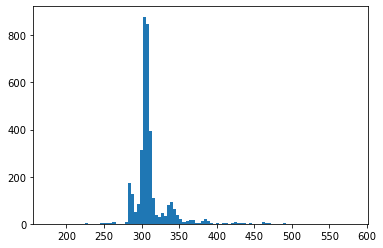

In [67]:
# visualize fit results
npz_file = np.load('muon_run1994.npz', allow_pickle=True)
mom_reco=npz_file['mom_reco']
fit_loss=npz_file['fit_loss']
print(len(mom_reco),np.min(mom_reco[mom_reco>-1]),np.max(mom_reco))
plt.hist(mom_reco,bins=100,range=[np.min(mom_reco[mom_reco>-1]),np.max(mom_reco)])

In [31]:
# Make event displays and loss surface scan

import os
geofile = cfg['detector']['geometry_definitions']['geofile']
detector_sensor = cfg['detector']['geometry_definitions']['sensor_radius']
per_mPMT = cfg['detector']['geometry_definitions']['per_mPMT']
tank = WCTE(geofile, detector_sensor,per_mPMT)
figdir = 'fig'
if (not os.path.exists(figdir)):
    os.makedirs(figdir)

pmt_mask[437] = 0
pmt_mask = pmt_mask.to(device)    

def make_prediction(mom):
    input_c = momentum_normalization(mom)*dummy_input+cherenkov_siren_input
    cherenkov_siren_output = cherenkov_siren(input_c)
    cherenkov_siren_output = cherenkov_siren_output*cherenkov_siren_output*cherenkov_factor #conversion to actual photon yield

    # Sum to get total charges per PMT
    optic_siren_input_ngamma = cherenkov_siren_output/nphi
    pmtQ_pred = optic_siren_input_ngamma*pred/n_gamma_model*pmt_qe
    pmtQ_pred = torch.sum(pmtQ_pred,dim=0)
    pmtQ_pred = pmtQ_pred*pmt_mask
    
    return pmtQ_pred

def make_event_display(idx, mom=None):
    ref_scale = torch.sum(make_prediction(vertex_momentum))
    
    if mom==None:
        pmtQ_pred = make_prediction(fitmom[idx])
    else:
        pmtQ_pred = make_prediction(mom)
    pmtQ_pred = pmtQ_pred*ref_scale/torch.sum(pmtQ_pred)
    
    pmtQ_true = pmtQ_data[idx].to(device)
    pmtQ_true = pmtQ_true*ref_scale/torch.sum(pmtQ_true)
    
    pmtQ_pred = pmtQ_pred.detach().cpu().numpy()
    pmtQ_true = pmtQ_true.detach().cpu().numpy()
    
    print(f'Event-{idx}, fitmom = {fitmom[idx]} MeV')
    maxq = np.max([pmtQ_pred,pmtQ_true])
    tank.show_2D_display(pmtQ_true,f'fig/ev_{idx}_data.pdf',None,None,0,np.max(pmtQ_true),False)
    tank.show_2D_display(pmtQ_pred,f'fig/ev_{idx}_reco.pdf',None,None,0,np.max(pmtQ_pred),False)

# Loss surface scan
def loss_surface_scan(idx):
    ref_scale = torch.sum(make_prediction(vertex_momentum))
    
    pmtQ_true = pmtQ_data[idx].to(device)
    pmtQ_true = pmtQ_true*ref_scale/torch.sum(pmtQ_true)
    
    mom_array = []
    loss_array = []
    
    for i in range (200,700,10):
        pmtQ_pred = make_prediction(i)
        pmtQ_pred = pmtQ_pred*ref_scale/torch.sum(pmtQ_pred)

        loss = loss_fn(pmtQ_pred,pmtQ_true) 
        mom_array.append(i)
        loss_array.append(loss.item())
    plt.scatter(mom_array,loss_array)


In [50]:
# Pick specific event for inspection
fitmom = np.array(mom_reco)

# Find index of elements
idx = np.where(fitmom < 196)
print("fitmom < 196: idx",idx[0])
idx = np.where((fitmom >340) & (fitmom <350))
print("(fitmom >340) & (fitmom <350): idx",idx[0])
idx = np.where(fitmom > 500)
print("fitmom > 500: idx",idx[0])

fitmom < 196: idx [1008 1285 2107]
(fitmom >340) & (fitmom <350): idx [  14   32   87  167  170  178  181  204  213  214  215  220  249  311
  353  388  442  474  480  492  513  535  604  622  636  663  709  750
  784  834  840  846  854  888  922  972  975 1014 1016 1060 1096 1121
 1142 1154 1166 1205 1214 1311 1364 1366 1386 1389 1405 1415 1420 1470
 1474 1504 1525 1559 1652 1683 1722 1799 1801 1807 1831 1855 1860 1918
 1920 1942 1990 1993 2001 2024 2070 2091 2136 2246 2259 2287 2289 2360
 2423 2431 2456 2483 2486 2511 2615 2617 2622 2643 2735 2752 2803 2804
 2817 2841 2846 2912 2965 2993 3000 3007 3036 3064 3068 3128 3146 3150
 3167 3176 3189 3197 3224 3245 3289 3301 3329 3333 3366 3406 3418 3446
 3476 3502 3508 3522 3526 3535 3558 3577 3612]
fitmom > 500: idx [1598 2977]


Event-2977, fitmom = 581.2067119404674 MeV


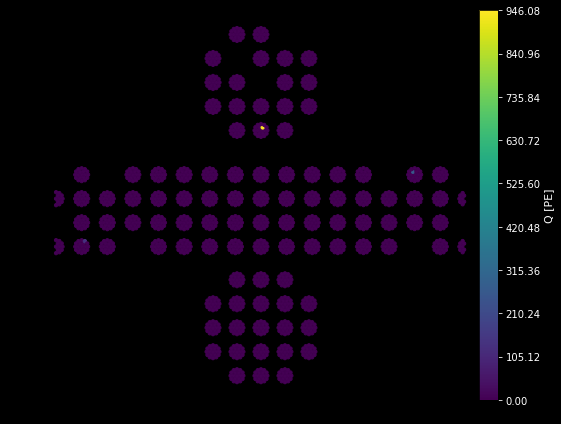

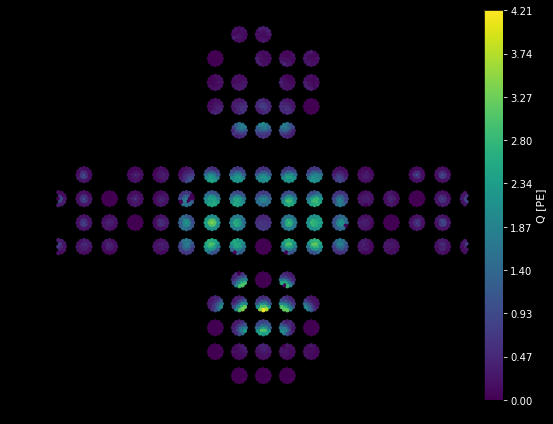

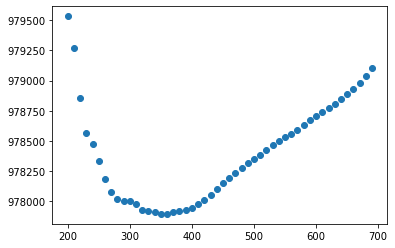

In [61]:
make_event_display(2977)
loss_surface_scan(2977)